In [7]:
import gzip
import pickle
import os
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from pylab import rcParams
import pandas as pd
import pystan
from matplotlib.ticker import MultipleLocator
from scipy.stats import gaussian_kde
import numpy as np
from datetime import datetime, timedelta
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [8]:
rcParams['figure.figsize'] = 16, 10
COMMON_SEED = 1234

def check_convergence(fit, also_print=False):
    report = print if also_print else lambda x: None
    
    def all_rhat_small_enough(fit):
        return all(dict(fit.summary())['summary'][:, -1] < 1.1)
    
    def max_treedepth_exceeded(fit, max_depth = 10):
        """Check transitions that ended prematurely due to maximum tree depth limit"""
        sampler_params = fit.get_sampler_params(inc_warmup=False)
        depths = [x for y in sampler_params for x in y['treedepth__']]
        n = sum(1 for x in depths if x == max_depth)
        if n > 0:
            report('Run again with max_depth set to a larger value to avoid saturation')        
        N = len(depths)
        report(('{} of {} iterations saturated the maximum tree depth of {}'
               + ' ({}%)').format(n, N, max_depth, 100 * n / N))
        return float(n) / N
    
    def e_bfmi_all_low_enough(fit):
        """
        Checks the energy Bayesian fraction of missing information (E-BFMI).
        E-BFMI below 0.2 indicates you may need to reparameterize your model
        """
        sampler_params = fit.get_sampler_params(inc_warmup=False)
        for chain_num, s in enumerate(sampler_params):
            energies = s['energy__']
            numer = sum((energies[i] - energies[i - 1])**2 for i in range(1, len(energies))) / len(energies)
            denom = np.var(energies)
            if numer / denom < 0.2:
                report('Chain {}: E-BFMI = {}'.format(chain_num, numer / denom))
                report('E-BFMI below 0.2 indicates you may need to reparameterize your model')
                return False
        return True

    def fraction_of_transitions_which_ended_with_divergence(fit):
        """Check transitions that ended with a divergence"""
        sampler_params = fit.get_sampler_params(inc_warmup=False)
        divergent = [x for y in sampler_params for x in y['divergent__']]
        n = sum(divergent)
        N = len(divergent)
        report('{} of {} iterations ended with a divergence ({}%)'
              .format(n, N, 100 * n / N))
        if n > 0:
            report('Try running with larger adapt_delta to remove the divergences')
        return n / N
    
    assert all_rhat_small_enough(fit)
    assert max_treedepth_exceeded(fit) < 0.02
    assert e_bfmi_all_low_enough(fit)
    assert fraction_of_transitions_which_ended_with_divergence(fit) <= 5E-3
    report("##### All convergence checks passed successfully. #####")

In [9]:
births_2000s_df = pd.read_csv('US_births_2000-2014_SSA.csv')
births_2000s_df_with_index = births_2000s_df\
    .rename(columns={'date_of_month': 'day'})\
    .set_index(pd.to_datetime(
        births_2000s_df.rename(columns={'date_of_month': 'day'})
        [['year', 'month', 'day']]))\
    .assign(weekday_name=lambda df: df.index.weekday_name)\
    .assign(day_of_year=lambda df: df.index.dayofyear)\
    .assign(week_of_year=lambda df: df.index.weekofyear)
births_2000s_df_with_index.tail()

,year,month,day,day_of_week,births,weekday_name,day_of_year,week_of_year
2014-12-27,2014,12,27,6,8656,Saturday,361,52
2014-12-28,2014,12,28,7,7724,Sunday,362,52
2014-12-29,2014,12,29,1,12811,Monday,363,1
2014-12-30,2014,12,30,2,13634,Tuesday,364,1
2014-12-31,2014,12,31,3,11990,Wednesday,365,1


In [10]:
def weekday_priors_by_year_2000():
    df_2000 = births_2000s_df_with_index[lambda df: df.year == 2000]
    return df_2000.groupby('day_of_week').agg(['mean', 'std']).births

weekday_priors_by_year_2000()

,mean,std
day_of_week,,
1,11514.461538,1036.715902
2,12870.846154,790.289954
3,12762.269231,422.905919
4,12735.461538,813.567006
5,12524.500000,634.105530
6,9049.830189,344.643056
7,8014.433962,310.302366


In [19]:
def priors_for_weekend_vs_workday_by_year_2000():
    df_2000 = births_2000s_df_with_index[lambda df: df.year == 2000]
    return df_2000\
        .assign(is_weekend=lambda df: df.day_of_week.isin([6, 7]))\
        .groupby('is_weekend')\
        .agg(['mean', 'std'])\
        .births

priors_for_weekend_vs_workday_by_year_2000()

,mean,std
is_weekend,,
False,12481.507692,909.221295
True,8532.132075,614.062616


In [11]:
def get_train_and_test_for_sliding_window(test_date):
    num_data_points_before_first_test_date = datetime(2014, 1, 1) - datetime(2001, 1, 1)
    df = births_2000s_df_with_index[['day_of_week', 'births']]\
        [lambda df: df.index <= test_date + timedelta(days=6)]\
        [lambda df: df.index >= test_date - num_data_points_before_first_test_date]
    return {
        'x_train': df.day_of_week[:-7].values,
        'y_train': df.births[:-7].values,
        'x_test': df.day_of_week[-7:].values,
        'y_test': df.births[-7:].values
    }
        
get_train_and_test_for_sliding_window(datetime(2014, 1, 1))

{'x_test': array([3, 4, 5, 6, 7, 1, 2]),
 'x_train': array([1, 2, 3, ..., 7, 1, 2]),
 'y_test': array([ 8018, 11171, 12317,  8199,  7174, 11400, 12310]),
 'y_train': array([ 7663, 10635, 12449, ...,  7896, 13096, 12525])}

In [12]:
def rmse(prediction_errors):
    return (prediction_errors ** 2).mean() ** 0.5

In [18]:
model_hier_negbin = pystan.StanModel(model_code='''
data {
    int<lower=0> T; // Number of predictions.
    int<lower=0> N; // Number of data points.
    int y_train[N]; // Train data points.
    int y_test[T]; // Test data points, for log-likelihood.
    int<lower=1,upper=7> x_train[N]; // Weekday indicator for each observed data point.
    int<lower=1,upper=7> x_test[T]; // Weekday indicator for each prediction.
    real<lower=0> prior_mean_weekend;
    real<lower=0> prior_mean_workday;
    real<lower=0> prior_std_weekend;
    real<lower=0> prior_std_workday;
    real<lower=0> V_lambda; // Std. dev. for priors on lambda.
    real<lower=0> V_sigma; // Std. dev. for priors on sigma.
    real<lower=0> V_phi; // Std. dev. for priors on phi.
    real<lower=0> prior_phi;
    real<lower=0> V_daily_phi;
}
parameters {
    real<lower=0> common_phi;
    real<lower=0> phi[7];
    real<lower=0> mu[7];
    real<lower=0> mu_weekend;
    real<lower=0> mu_workday;
    real<lower=0> sigma_weekend;
    real<lower=0> sigma_workday;
}
model {
    common_phi ~ normal(prior_phi, V_phi * prior_phi);
    mu_weekend ~ normal(prior_mean_weekend, V_lambda * prior_std_weekend);
    mu_workday ~ normal(prior_mean_workday, V_lambda * prior_std_workday);
    sigma_weekend ~ normal(prior_std_weekend, V_sigma * prior_std_weekend);
    sigma_workday ~ normal(prior_std_workday, V_sigma * prior_std_workday);
    mu[6] ~ normal(mu_weekend, sigma_weekend);
    mu[7] ~ normal(mu_weekend, sigma_weekend);
    for (i in 1:5) {
        mu[i] ~ normal(mu_workday, sigma_workday);
    }
    phi ~ cauchy(common_phi, V_daily_phi * common_phi);
    y_train ~ neg_binomial_2(mu[x_train], phi[x_train]);
}
generated quantities {
    real loglik;
    vector[T] y_pred;
    loglik = 0;
    for (t in 1:T) {
        y_pred[t] = neg_binomial_2_rng(mu[x_test[t]], phi[x_test[t]]);
        loglik += neg_binomial_2_lpmf(y_test[t] | mu[x_test[t]], phi[x_test[t]]);
    }
}
''')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1f5534f9f16a420dad5dd0b0607ea807 NOW.


In [15]:
prior_stds = weekday_priors_by_year_2000()['std'].values
prior_mu = weekday_priors_by_year_2000()['mean'].values
prior_phi = (prior_mu ** 2) / (prior_stds ** 2 - prior_mu)
print("prior_stds:", prior_stds, "prior_mu:", prior_mu, "prior_phi:", prior_phi, sep="\n")

prior_stds:
[1036.71590189  790.28995385  422.90591896  813.56700585  634.10553028
  344.64305592  310.30236553]
prior_mu:
[11514.46153846 12870.84615385 12762.26923077 12735.46153846
 12524.5         9049.83018868  8014.43396226]
prior_phi:
[124.69400825 270.82246617 980.66297605 249.85061788 402.66186638
 746.37900747 727.64108437]


In [20]:
# Second week of 2014.
data = get_train_and_test_for_sliding_window(datetime(2014, 1, 1) + timedelta(days=7))
fit = model_hier_negbin.sampling(seed=COMMON_SEED, iter=500, data=dict(
        V_daily_phi=0.02,
        prior_phi=prior_phi.mean(),
        V_phi=1,
        V_lambda=4,
        V_sigma=0.2,
        prior_mean_weekend=priors_for_weekend_vs_workday_by_year_2000()[lambda df: df.index == True]['mean'].values[0],
        prior_mean_workday=priors_for_weekend_vs_workday_by_year_2000()[lambda df: df.index == False]['mean'].values[0],
        prior_std_workday=priors_for_weekend_vs_workday_by_year_2000()[lambda df: df.index == False]['std'].values[0],
        prior_std_weekend=priors_for_weekend_vs_workday_by_year_2000()[lambda df: df.index == True]['std'].values[0],
        x_train=data['x_train'],
        x_test=data['x_test'],
        y_train=data['y_train'],
        y_test=data['y_test'],
        T=7,
        N=len(data['x_train'])))

In [21]:
check_convergence(fit)

In [22]:
fit

Inference for Stan model: anon_model_1f5534f9f16a420dad5dd0b0607ea807.
4 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=1000.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
common_phi    170.19    0.62  10.53  148.2 163.09 170.71  177.8 189.55    290    1.0
phi[0]         86.91    0.19   4.88  77.56  83.37  86.94  89.99  96.64    633    1.0
phi[1]         171.4    0.45   8.86  154.4 165.13 171.48 177.54 188.37    380    1.0
phi[2]         175.9    0.44   8.69 158.91 170.01 175.92 181.61 193.83    393    1.0
phi[3]         96.52     0.2    5.1  86.85  92.78  96.48  99.86 107.12    641    1.0
phi[4]        147.95    0.36   8.72 131.08 141.96  147.8 154.07 164.63    594    1.0
phi[5]        297.99    0.72  16.82 266.22 285.79  297.5  309.6 330.65    540    1.0
phi[6]        387.91    0.78  21.97 345.84 374.05 387.58 402.14 432.79    800    1.0
mu[0]          1.2e4    1.63  51.52  1.2e4  1.2e4

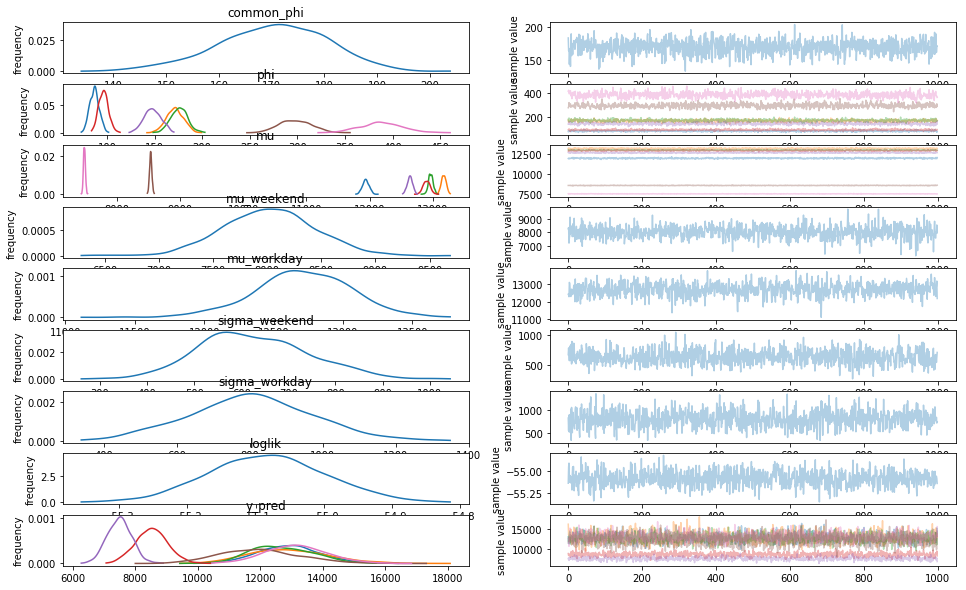

In [23]:
fit.plot();

In [34]:
rmse(fit.extract()["y_pred"].mean(axis=0) - data["y_test"])

697.9216388517925

In [35]:
def hier_negbin_data_extractor(data):
    return dict(
        V_daily_phi=0.02,
        prior_phi=prior_phi.mean(),
        V_phi=1,
        V_lambda=4,
        V_sigma=0.2,
        prior_mean_weekend=priors_for_weekend_vs_workday_by_year_2000()[lambda df: df.index == True]['mean'].values[0],
        prior_mean_workday=priors_for_weekend_vs_workday_by_year_2000()[lambda df: df.index == False]['mean'].values[0],
        prior_std_workday=priors_for_weekend_vs_workday_by_year_2000()[lambda df: df.index == False]['std'].values[0],
        prior_std_weekend=priors_for_weekend_vs_workday_by_year_2000()[lambda df: df.index == True]['std'].values[0],
        x_train=data['x_train'],
        x_test=data['x_test'],
        y_train=data['y_train'],
        y_test=data['y_test'],
        T=7,
        N=len(data['x_train']))

In [36]:
def fit_stan_model_on_sliding_windows(iterations, stan_data_extractor, persist_path, stan_model, num_windows):
    if not os.path.exists(persist_path):
        os.mkdir(persist_path)
    all_prediction_errors = []
    for i in range(num_windows):
        data = get_train_and_test_for_sliding_window(datetime(2014, 1, 1) + timedelta(days=i * 7))
        fit = stan_model.sampling(seed=COMMON_SEED, data=stan_data_extractor(data), iter=iterations, chains=1,
                                 control=dict(adapt_delta=0.99, max_treedepth=20))
        print(fit)
        check_convergence(fit, also_print=True)
        pred_err = fit.extract()['y_pred'].mean(axis=0) - data['y_test']
        all_prediction_errors.append(pred_err)
        with gzip.open(os.path.join(persist_path, 'fit%d_summary.pkl.gz' % i), 'wb') as f:
            pickle.dump(fit.summary(), f)
        with gzip.open(os.path.join(persist_path, 'fit%d_extract.pkl.gz' % i), 'wb') as f:
            pickle.dump(fit.extract(), f)         
        with gzip.open(os.path.join(persist_path, 'fit%d_pred_err.pkl.gz' % i), 'wb') as f:
            pickle.dump(pred_err, f)
        with gzip.open(os.path.join(persist_path, 'fit%d_y_test.pkl.gz' % i), 'wb') as f:
            pickle.dump(data['y_test'], f)
        with gzip.open(os.path.join(persist_path, 'fit%d.pkl.gz' % i), 'wb') as f:
            pickle.dump(fit, f)                        
    return rmse(np.concatenate(all_prediction_errors))

In [39]:
%%time

# Quick check: one time window.
fit_stan_model_on_sliding_windows(
    500,
    hier_negbin_data_extractor,
    'hier_negbin_one_phi', 
    model_hier_negbin,
    1)

Inference for Stan model: anon_model_1f5534f9f16a420dad5dd0b0607ea807.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
common_phi    172.59    2.09  14.45 146.67 161.96 173.62 182.61 200.77     48   1.02
phi[0]          85.4    0.31   4.45  76.37  82.86  85.14  88.14  95.15    206    1.0
phi[1]        171.93    1.28   10.8 150.16  164.5  172.5 179.38 191.85     71   1.02
phi[2]        184.56     0.9  10.77 162.58  178.5 184.23 191.35 206.66    142    1.0
phi[3]          96.7    0.36   5.08   87.3  93.13   96.1 100.44 107.95    203    1.0
phi[4]        146.36    0.76   9.33 127.32 140.39 145.84 151.99  164.3    152    1.0
phi[5]        294.76    1.38  17.64  260.6  283.8 293.72 305.93  335.6    163    1.0
phi[6]        387.63     2.0   21.1 342.52 375.37  387.6 399.48 429.88    111    1.0
mu[0]          1.2e4    3.24   51.3  1.2e4  1.2e4 

/home/inonpe/jupyter/dtu_bda_project/env/lib/python3.5/site-packages/ipykernel_launcher.py:22: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.


CPU times: user 6min 26s, sys: 456 ms, total: 6min 27s
Wall time: 6min 26s


2048.2154705814382

In [ ]:
%%time

# All time windows.
fit_stan_model_on_sliding_windows(
    500,
    separate_negbin_data_extractor,
    'fit_separate_negbin', 
    model_separate_weekdays,
    52)

Inference for Stan model: anon_model_424ae25909336bda8789dc6180cfae2a.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]      1.2e4    2.83  44.71  1.2e4  1.2e4  1.2e4  1.2e4  1.2e4    250    1.0
mu[1]      1.3e4    2.44  38.62  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[2]      1.3e4    2.21  34.94  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[3]      1.3e4    3.24  51.19  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[4]      1.3e4     2.4  37.95  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[5]     8539.1    1.32  20.82 8503.3 8523.4 8540.5 8552.0 8584.0    250    1.0
mu[6]     7488.7    1.12  17.65 7455.4 7476.8 7488.2 7500.2 7524.7    250    1.0
phi[0]     85.17    0.26   4.07  76.84  82.56  85.31  87.77  93.55    250    1.0
phi[1]    171.68    0.72   9.44  152.4 166.46 172.04 178.36 190.91    171    1.0
phi[2

/home/inonpe/jupyter/dtu_bda_project/env/lib/python3.5/site-packages/ipykernel_launcher.py:22: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.


Inference for Stan model: anon_model_424ae25909336bda8789dc6180cfae2a.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]      1.2e4    3.37   53.3  1.2e4  1.2e4  1.2e4  1.2e4  1.2e4    250    1.0
mu[1]      1.3e4    2.55  40.33  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[2]      1.3e4    2.12  33.55  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[3]      1.3e4    3.09  48.86  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[4]      1.3e4    2.31  36.47  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[5]     8538.0    1.29  20.44 8495.4 8524.9 8539.0 8552.0 8576.2    250    1.0
mu[6]     7488.3     1.0  13.92 7460.0 7479.8 7488.6 7498.7 7514.7    194    1.0
phi[0]     86.51    0.36   5.21  75.44  82.55  86.73  90.27  95.36    205   1.02
phi[1]    173.19    0.73  10.12 154.52 166.55 173.52 179.86 191.78    191    1.0
phi[2